In [1]:
from multiprocessing import Pool,Process,Manager,cpu_count
import math
import numpy as np
import pylab
import time
from pathlib import Path
import numpy as np
from PyBoltz.PyBoltzRun import *
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data


def Plotabble(Files,Skip):
    
    ### Structure
    # Efield --> 1atm to 10atm
    
    Pressure=np.arange(1+Skip,11,1)
    values=PickleITRead(Files)
    Efield_dic={}
    VectorSize=10-Skip
    for key,value in values.items():
        Splitted=key.split("_")
        
        fVel=float(value["Drift_vel"][0])
        fVelError=float(value["Drift_vel"][1])
        
        fDT=float(value["DT"][0])
        fDTError=float(value["DT"][1])
        
        fDL=float(value["DL"][0])
        fDLError=float(value["DL"][1])
        
        if(Skip):
            Index=round(float(Splitted[1])*0.00133322)-1-Skip
            if(Index<0): continue
        else:
            Index=round(float(Splitted[1])*0.00133322)-1
            
        Efield=round(float(Splitted[0]))
       
        if(Efield in Efield_dic):
            Efield_dic[Efield]["Drift_vel"][0][Index]=fVel
            Efield_dic[Efield]["Drift_vel"][1][Index]=fVelError
            Efield_dic[Efield]["DT"][0][Index]=fDT
            Efield_dic[Efield]["DT"][1][Index]=fDTError
            Efield_dic[Efield]["DL"][0][Index]=fDL
            Efield_dic[Efield]["DL"][1][Index]=fDLError
            Efield_dic[Efield]["ReducedField"][Index]=Efield/(Index+1)


        else:
            SingleValue_dict={}
            # Drift Velocity array
            DriftVelocity=np.zeros(VectorSize)
            DriftVelError=np.zeros(VectorSize)
            
            # Transverse Diffusion
            DT=np.zeros(VectorSize)
            DTError=np.zeros(VectorSize)

            #Longotituonal Diffusion
            DL=np.zeros(VectorSize)
            DLError=np.zeros(VectorSize)
            ReducedField=np.zeros(VectorSize)
            
            ## Insert values
            DriftVelocity[Index]=fVel
            DriftVelError[Index]=fVelError
            DT[Index]=fDT
            DTError[Index]=fDTError
            DL[Index]=fDL
            DLError[Index]=fDLError
            ReducedField[Index]=Efield/(Index+1)
            
            SingleValue_dict["Drift_vel"]=[DriftVelocity,DriftVelError]
            SingleValue_dict["DT"]=[DT,DTError]
            SingleValue_dict["DL"]=[DL,DLError]
            SingleValue_dict["ReducedField"]=ReducedField
            Efield_dic[Efield]=SingleValue_dict.copy()
        
    plottable=ConvertToReduceEField(Efield_dic)
    return Efield_dic,Pressure,plottable

def ConvertToReduceEField(data):
    vv={}
    vv["ReducedField"]=[]
    vv["Drift_vel"]=[[],[]]
    vv["DL"]=[[],[]]
    vv["DT"]=[[],[]]
    for Efield in data:
        vv["ReducedField"]=np.append(vv["ReducedField"],data[Efield]["ReducedField"])
        vv["Drift_vel"][0]=np.append(vv["Drift_vel"][0],data[Efield]["Drift_vel"][0])
        vv["Drift_vel"][1]=np.append(vv["Drift_vel"][1],data[Efield]["Drift_vel"][1])
        vv["DL"][0]=np.append(vv["DL"][0],data[Efield]["DL"][0])
        vv["DL"][1]=np.append(vv["DL"][1],data[Efield]["DL"][1])
        vv["DT"][0]=np.append(vv["DT"][0],data[Efield]["DT"][0])
        vv["DT"][1]=np.append(vv["DT"][1],data[Efield]["DT"][1])

                
    return vv        
        
        
        
        

In [15]:
Skip=0
XENON_85_CO2_15=Plotabble("/home/ilker/CRAB/Diffusion/Diffusion_XENON_85_CO2_15.p",Skip)[2]
XENON_90_CO2_10=Plotabble("/home/ilker/CRAB/Diffusion/Diffusion_XENON_90_CO2_10.p",Skip)[2]
XENON_95_CO2_5=Plotabble("/home/ilker/CRAB/Diffusion/Diffusion_XENON_95_CO2_5.p",Skip)[2]
XENON_100=Plotabble("/home/ilker/CRAB/Diff/XENON",Skip)[2]

XENON_85_He_15=Plotabble("/home/ilker/CRAB/Diffusion/Diffusion_XENON_85_HELIUM4_15.p",Skip)[2]
XENON_90_He_10=Plotabble("/home/ilker/CRAB/Diffusion/Diffusion_XENON_90_HELIUM4_10.p",Skip)[2]
XENON_95_He_5=Plotabble("/home/ilker/CRAB/Diffusion/Diffusion_XENON_95_HELIUM4_5.p",Skip)[2]
XENON_85_Ne_15=Plotabble("/home/ilker/CRAB/Diffusion/Diffusion_XENON_85_NEON_15.p",Skip)[2]

In [3]:
t=PickleITRead("/home/ilker/CRAB/Diffusion/Diffusion_XENON_85_CO2_15.p")

In [4]:
print(t)

{'100.0_7500.62': {'Drift_vel': [0.12820308601836455, 0.001960303223986761], 'DT': [3.202774098638646, 0.03044561857946488], 'DL': [3.16497404235148, 0.04287940612151468]}, '100.0_3000.248': {'Drift_vel': [0.3177961478872766, 0.0017700592675251353], 'DT': [8.122868976410553, 0.08953325568102301], 'DL': [8.06641792068497, 0.10709989196555313]}, '100.0_6750.558': {'Drift_vel': [0.1409578034530178, 0.0015522989573334492], 'DT': [3.5867366816332593, 0.037922521722908935], 'DL': [3.5284247262351323, 0.05168711625433033]}, '300.0_1500.124': {'Drift_vel': [1.9761484957021314, 0.0011267948048981258], 'DT': [19.17415211162499, 0.22329096735813742], 'DL': [20.620565004911597, 0.26630343747572965]}, '100.0_5250.434': {'Drift_vel': [0.1861343713784639, 0.00127936590920835], 'DT': [4.583088839718356, 0.05292210699856758], 'DL': [4.545818442391394, 0.036886043462011776]}, '100.0_4500.372': {'Drift_vel': [0.2140621021858519, 0.002295795838853612], 'DT': [5.290694482992139, 0.06201049480110241], 'DL':

[100.          50.          33.33333333  25.          20.
  16.66666667  14.28571429  12.5         11.11111111  10.
 300.         150.         100.          75.          60.
  50.          42.85714286  37.5         33.33333333  30.
 500.         250.         166.66666667 125.         100.
  83.33333333  71.42857143  62.5         55.55555556  50.        ]


array([2.76950774, 2.53009257, 1.68334398, 0.99680746, 0.61978572,
       0.4223132 , 0.3134201 , 0.25447799, 0.22008365, 0.18377489,
       2.52777416, 2.67191373, 2.76950774, 2.77890739, 2.70912271,
       2.53170362, 2.26854745, 1.97421188, 1.67201059, 1.41756155,
       2.50077694, 2.55460283, 2.64281066, 2.71548544, 2.76950774,
       2.79887798, 2.77585821, 2.74005611, 2.65456155, 2.52984893])

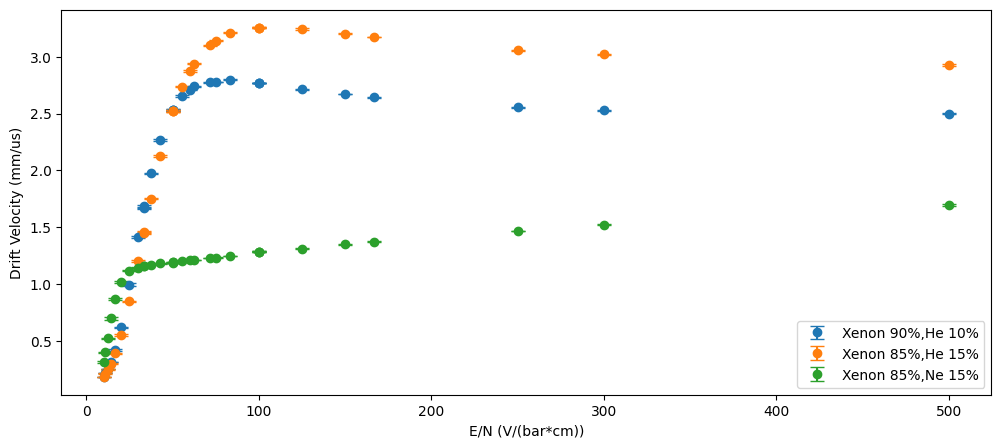

In [16]:
plt.figure(figsize=(12,5))
#plt.errorbar(XENON_100["ReducedField"],XENON_100["Drift_vel"][0],yerr=XENON_100["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 100%")
#plt.errorbar(XENON_95_He_5["ReducedField"],XENON_95_He_5["Drift_vel"][0],yerr=XENON_95_He_5["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 95%,He 5%")
#plt.errorbar(XENON_95_CO2_5["ReducedField"],XENON_95_CO2_5["Drift_vel"][0],yerr=XENON_95_CO2_5["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 95%,CO2 5%")
plt.errorbar(XENON_90_He_10["ReducedField"],XENON_90_He_10["Drift_vel"][0],yerr=XENON_90_He_10["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 90%,He 10%")
#plt.errorbar(XENON_90_CO2_10["ReducedField"],XENON_90_CO2_10["Drift_vel"][0],yerr=XENON_90_CO2_10["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 90%,CO2 10%")
plt.errorbar(XENON_85_He_15["ReducedField"],XENON_85_He_15["Drift_vel"][0],yerr=XENON_85_He_15["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 85%,He 15%")
#plt.errorbar(XENON_85_CO2_15["ReducedField"],XENON_85_CO2_15["Drift_vel"][0],yerr=XENON_85_CO2_15["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 85%,CO2 15%")
plt.errorbar(XENON_85_Ne_15["ReducedField"],XENON_85_Ne_15["Drift_vel"][0],yerr=XENON_85_Ne_15["Drift_vel"][1],capsize=5,fmt='o',label="Xenon 85%,Ne 15%")

plt.xlabel("E/N (V/(bar*cm))")
plt.ylabel("Drift Velocity (mm/us)")
#plt.semilogx()
plt.legend()

print(XENON_90_He_10["ReducedField"])
XENON_90_He_10["Drift_vel"][0]

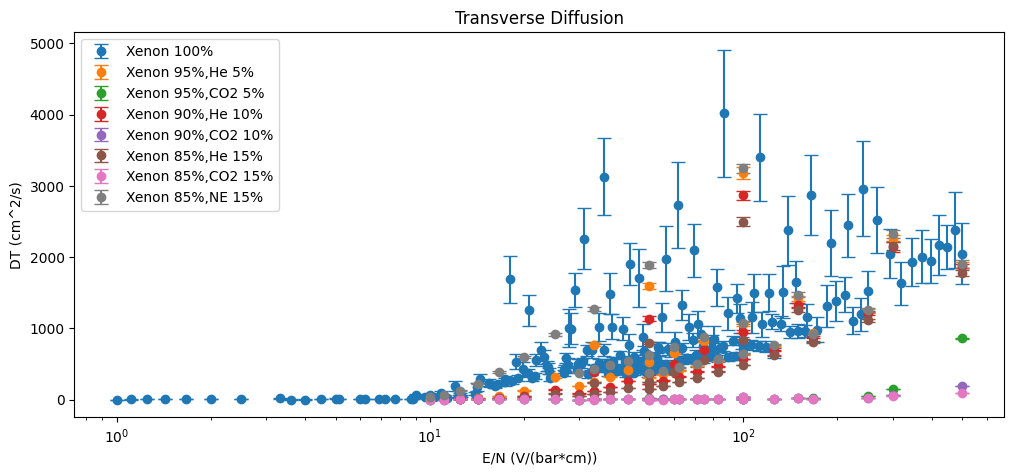

In [18]:

plt.figure(figsize=(12,5))
plt.title("Transverse Diffusion")
plt.errorbar(XENON_100["ReducedField"],XENON_100["DT"][0],yerr=XENON_100["DT"][1],capsize=5,fmt='o',label="Xenon 100%")
plt.errorbar(XENON_95_He_5["ReducedField"],XENON_95_He_5["DT"][0],yerr=XENON_95_He_5["DT"][1],capsize=5,fmt='o',label="Xenon 95%,He 5%")
plt.errorbar(XENON_95_CO2_5["ReducedField"],XENON_95_CO2_5["DT"][0],yerr=XENON_95_CO2_5["DT"][1],capsize=5,fmt='o',label="Xenon 95%,CO2 5%")
plt.errorbar(XENON_90_He_10["ReducedField"],XENON_90_He_10["DT"][0],yerr=XENON_90_He_10["DT"][1],capsize=5,fmt='o',label="Xenon 90%,He 10%")
plt.errorbar(XENON_90_CO2_10["ReducedField"],XENON_90_CO2_10["DT"][0],yerr=XENON_90_CO2_10["DT"][1],capsize=5,fmt='o',label="Xenon 90%,CO2 10%")
plt.errorbar(XENON_85_He_15["ReducedField"],XENON_85_He_15["DT"][0],yerr=XENON_85_He_15["DT"][1],capsize=5,fmt='o',label="Xenon 85%,He 15%")
plt.errorbar(XENON_85_CO2_15["ReducedField"],XENON_85_CO2_15["DT"][0],yerr=XENON_85_CO2_15["DT"][1],capsize=5,fmt='o',label="Xenon 85%,CO2 15%")
plt.errorbar(XENON_85_Ne_15["ReducedField"],XENON_85_Ne_15["DT"][0],yerr=XENON_85_Ne_15["DT"][1],capsize=5,fmt='o',label="Xenon 85%,NE 15%")

plt.ylabel("DT (cm^2/s)")
plt.xlabel("E/N (V/(bar*cm))")
plt.semilogx()
plt.legend()
plt.show()

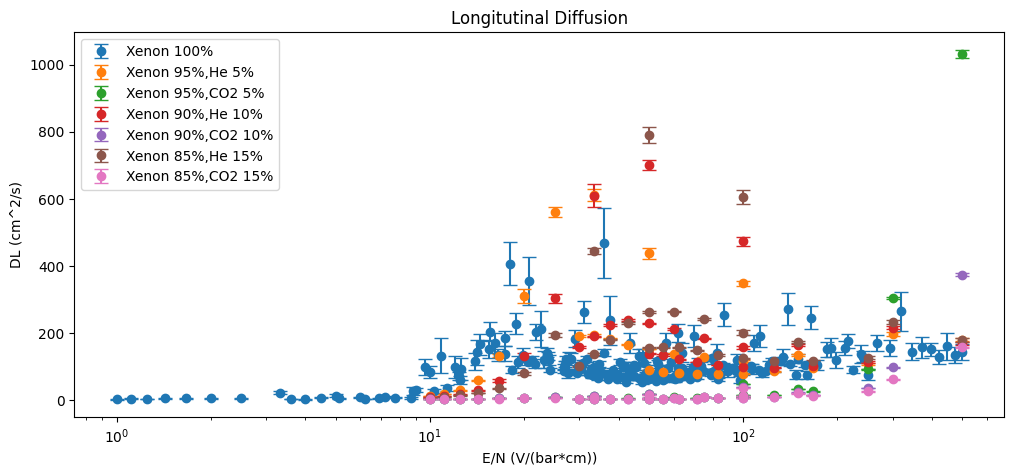

In [6]:
plt.figure(figsize=(12,5))
plt.title("Longitutinal Diffusion")
plt.errorbar(XENON_100["ReducedField"],XENON_100["DL"][0],yerr=XENON_100["DL"][1],capsize=5,fmt='o',label="Xenon 100%")
plt.errorbar(XENON_95_He_5["ReducedField"],XENON_95_He_5["DL"][0],yerr=XENON_95_He_5["DL"][1],capsize=5,fmt='o',label="Xenon 95%,He 5%")
plt.errorbar(XENON_95_CO2_5["ReducedField"],XENON_95_CO2_5["DL"][0],yerr=XENON_95_CO2_5["DL"][1],capsize=5,fmt='o',label="Xenon 95%,CO2 5%")
plt.errorbar(XENON_90_He_10["ReducedField"],XENON_90_He_10["DL"][0],yerr=XENON_90_He_10["DL"][1],capsize=5,fmt='o',label="Xenon 90%,He 10%")
plt.errorbar(XENON_90_CO2_10["ReducedField"],XENON_90_CO2_10["DL"][0],yerr=XENON_90_CO2_10["DL"][1],capsize=5,fmt='o',label="Xenon 90%,CO2 10%")
plt.errorbar(XENON_85_He_15["ReducedField"],XENON_85_He_15["DL"][0],yerr=XENON_85_He_15["DL"][1],capsize=5,fmt='o',label="Xenon 85%,He 15%")
plt.errorbar(XENON_85_CO2_15["ReducedField"],XENON_85_CO2_15["DL"][0],yerr=XENON_85_CO2_15["DL"][1],capsize=5,fmt='o',label="Xenon 85%,CO2 15%")

plt.ylabel("DL (cm^2/s)")
plt.xlabel("E/N (V/(bar*cm))")
plt.semilogx()
plt.legend()
plt.show()

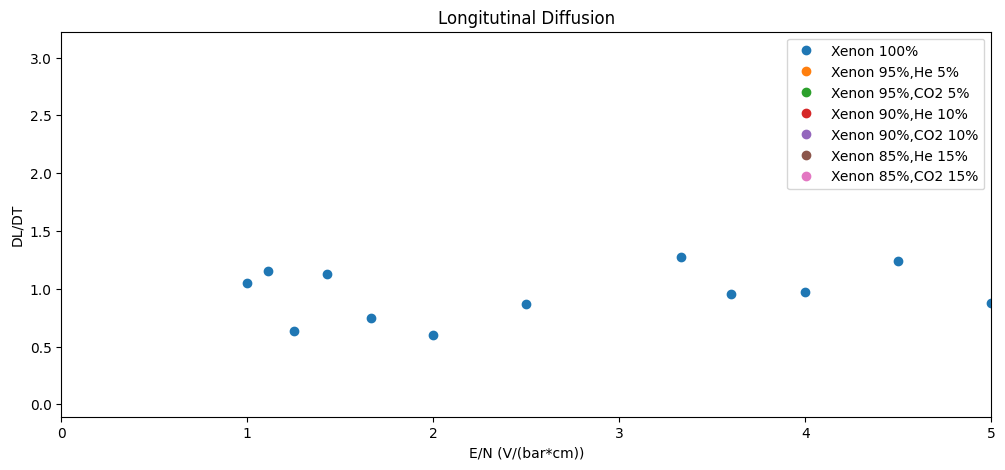

In [7]:
plt.figure(figsize=(12,5))
plt.title("Longitutinal Diffusion")
plt.errorbar(XENON_100["ReducedField"],XENON_100["DL"][0]/XENON_100["DT"][0],capsize=5,fmt='o',label="Xenon 100%")
plt.errorbar(XENON_95_He_5["ReducedField"],XENON_95_He_5["DL"][0]/XENON_95_He_5["DT"][0],capsize=5,fmt='o',label="Xenon 95%,He 5%")
plt.errorbar(XENON_95_CO2_5["ReducedField"],XENON_95_CO2_5["DL"][0]/XENON_95_CO2_5["DT"][0],capsize=5,fmt='o',label="Xenon 95%,CO2 5%")
plt.errorbar(XENON_90_He_10["ReducedField"],XENON_90_He_10["DL"][0]/XENON_90_He_10["DT"][0],capsize=5,fmt='o',label="Xenon 90%,He 10%")
plt.errorbar(XENON_90_CO2_10["ReducedField"],XENON_90_CO2_10["DL"][0]/XENON_90_CO2_10["DT"][0],capsize=5,fmt='o',label="Xenon 90%,CO2 10%")
plt.errorbar(XENON_85_He_15["ReducedField"],XENON_85_He_15["DL"][0]/XENON_85_He_15["DT"][0],capsize=5,fmt='o',label="Xenon 85%,He 15%")
plt.errorbar(XENON_85_CO2_15["ReducedField"],XENON_85_CO2_15["DL"][0]/XENON_85_CO2_15["DT"][0],capsize=5,fmt='o',label="Xenon 85%,CO2 15%")

plt.ylabel("DL/DT")
plt.xlabel("E/N (V/(bar*cm))")
plt.xlim(0,5)
plt.legend()
plt.show()